<a href="https://colab.research.google.com/github/HeqingZ/FLIRthermal-COCO-detection-R_50_FPN_1x/blob/main/%E7%AC%AC%E4%B8%80%E9%81%8D%E8%B7%91thermal%E5%A4%A7%E6%95%B0%E6%8D%AER_50_FPN_1x(FINISHED).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 4.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=d330f2a132ef03fd8f3a581f5174688cd976ba14f7ff766a70eeface74eb6130
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wkvmkwop
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wkvmkwop
     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 79 kB 

In [ ]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [ ]:
#mount on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [ ]:
DatasetCatalog.clear() #unregister stuff

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
    MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")


In [ ]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("FLIR_THERMAL_train_data",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people #changed to 16 jul 15. generally speaking 2-8 works.# Jul 15 try: 4
cfg.SOLVER.BASE_LR = 0.02  # pick a good LR #first try 0.2 doesnt work. #second try 0.0025, 36min. #third try 0.025, 3h. bad stuff #4th try 0.02, doesnt work. #5th time 0.002
cfg.SOLVER.MAX_ITER = 90000    # first iter 300, doesnt work. #second iter 10000, doesnt work #3rd iter 90000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
cfg.MODEL.BACKBONE.FREEZE_AT = 0

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[07/15 19:03:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:06, 15.0MB/s]                           


[07/15 19:15:44 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/15 19:15:44 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[07/15 19:15:47 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/15 19:16:02 d2.utils.events]:  eta: 8:19:19  iter: 19  total_loss: 1.124  loss_cls: 0.1656  loss_box_reg: 0.003207  loss_rpn_cls: 0.6507  loss_rpn_loc: 0.2418  time: 0.3315  data_time: 0.0348  lr: 0.00039962  max_mem: 4990M
[07/15 19:16:08 d2.utils.events]:  eta: 8:23:41  iter: 39  total_loss: 0.8675  loss_cls: 0.1163  loss_box_reg: 0.007401  loss_rpn_cls: 0.4746  loss_rpn_loc: 0.2496  time: 0.3347  data_time: 0.0252  lr: 0.00079922  max_mem: 4990M
[07/15 19:16:15 d2.utils.events]:  eta: 8:11:37  iter: 59  total_loss: 0.5175  loss_cls: 0.08556  loss_box_reg: 0.02467  loss_rpn_cls: 0.1951  loss_rpn_loc: 0.1716  time: 0.3313  data_time: 0.0236  lr: 0.0011988  max_mem: 4990M
[07/15 19:16:21 d2.utils.events]:  eta: 8:12:14  iter: 79  total_loss: 0.5067  loss_cls: 0.1035  loss_box_reg: 0.04499  loss_rpn_cls: 0.1501  loss_rpn_loc: 0.1956  time: 0.3297  data_time: 0.0244  lr: 0.0015984  max_mem: 4990M
[07/15 19:16:28 d2.utils.events]:  eta: 8:14:49  iter: 99  total_loss: 0.5707  loss_cls:

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

跑完training之后一定一定一定要把之前的model全都删了！

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

[07/16 03:50:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [ ]:
from google.colab import files
files.download('/content/output/model_final.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

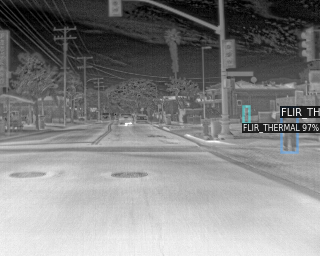

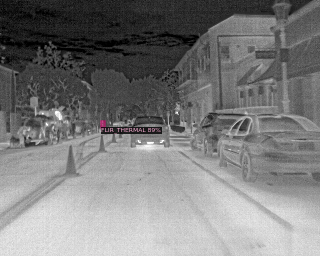

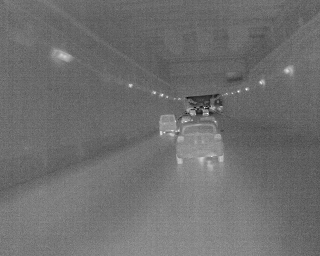

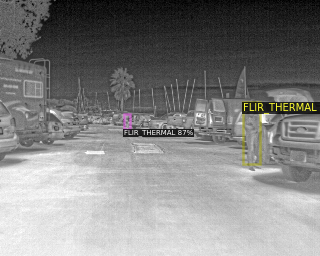

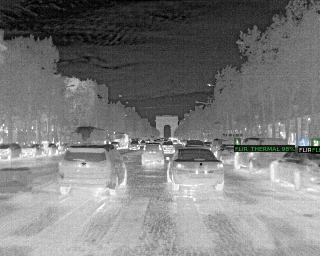

In [ ]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_train_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/16 04:21:37 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

OrderedDict([('bbox',
              {'AP': 53.254295500290624,
               'AP50': 90.14543374310658,
               'AP75': 56.16730647126308,
               'APl': 70.34139125612093,
               'APm': 68.3551734388598,
               'APs': 48.72142320951365})])